In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import os
import pickle

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

# Support Vector Regression (SVR) with radial basis functions
Implementation aligned with publication: Predicting the Gaze Depth in Head-mounted Displays using Multiple Feature Regression:  

Martin Weier, Thorsten Roth, André Hinkenjann, and Philipp Slusallek. 2018. _Predicting the gaze depth in head-mounted displays using multiple feature regression._  
In Proceedings of the 2018 ACM Symposium on Eye Tracking Research & Applications (ETRA '18). Association for Computing Machinery, New York, NY, USA, Article 19, 1–9.  
https://doi.org/10.1145/3204493.3204547

### Feature Set (Weier et al., 2018)
| **Feature** | **Description**                                                   |
|-------------|-------------------------------------------------------------------|
| **Center**  | Depth at the PoR (depth buffer)                                   |
| **Mean**    | Mean of the samples around the PoR (depth buffer)                 |
| **Var.**    | Variance of the samples around the PoR (depth buffer)             |
| **Ray**     | Ray-based depth estimate (vergence)                               |
| **Wang**    | Method by Wang et al. [Wang et al. 2012] (vergence)               |
| **Ecc.**    | Eccentricity of the PoR regarding the screen center               |

### Details
- Hyperparameters tuned with Cross Validation (regularization parameter C (and kernel coefficient Gamma))  
- Training on all participants combined instead of one model for each participant

### Notes
- Parameters of SVR with rbf:  
        - kernel = rbf  
        - gamma = scale? (default of "scale": 1 / (n_features * X.var()))  
        - C = [0.001, 0.01, 0.1, 1, 10, 100] -> cross validation  
- 20 Samples for feature set randomly within 1deg around the PoR (center gaze)

In [ ]:
current_path = os.getcwd()

# the data was preprocessed and saved as feather file
path = os.path.abspath(os.path.join(current_path, '..', 'data', 'training_data_10percent_ang2.feather'))
data = pd.read_feather(path)

# check whether the model already exists
model = None
model_exists = False
filename = 'model_filtered_data_C_eps.sav'

if os.path.exists(filename):
    model_exists = True
    model = pickle.load(open(filename, 'rb'))

# filtering
data = data.dropna()
data = data[np.isfinite(data).all(1)]

display(data)

# initialize training data
df_X = data[['center', 'mean_distance', 'var_distance', 'ray', 'wang', 'ecc']]
df_distance_y = data['distance']

X_train, X_test, y_train, y_test = train_test_split(df_X, df_distance_y, test_size=0.2, random_state=42)

print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

y_preds = []
y_tests = []

#ä figure details
figwidth_fraction = 0.8
base_font_size_labels = 8
base_font_size_ticks = 7

label_font_size = base_font_size_labels / figwidth_fraction
tick_font_size = base_font_size_ticks / figwidth_fraction

params_plt = {'legend.fontsize': label_font_size,
         'axes.labelsize': label_font_size,
         'axes.titlesize': label_font_size,
         'xtick.labelsize': tick_font_size,
         'ytick.labelsize': tick_font_size}
pylab.rcParams.update(params_plt)

,center,mean_distance,var_distance,mean_depth,var_depth,ray,wang,ecc,depth,distance,target_id,participant_id
0,1.544952,3.322812,22.043843,3.274803,21.409767,1.606021,5.088074,15.314340,1.696917,1.767207,49,3
1,1.542664,4.404449,26.803968,4.337692,25.992190,2.355448,3.276621,15.504886,1.696417,1.767572,49,3
2,1.542664,4.946989,28.248053,4.873047,27.405934,2.460311,3.707560,15.471276,1.696357,1.767682,49,3
3,1.545715,2.307423,14.885663,2.273388,14.444923,1.394218,7.026976,15.356790,1.696655,1.766827,49,3
4,1.554108,4.952059,28.212593,4.883499,27.440488,1.896065,4.196672,15.264259,1.696139,1.767345,49,3
...,...,...,...,...,...,...,...,...,...,...,...,...
110991,9.197998,5.879433,0.013101,5.866394,0.012912,1.643606,1.698829,10.021590,2.357617,2.397376,108,43
110992,10.101318,5.896088,0.007952,5.882416,0.007655,1.717163,1.737268,10.113519,2.356761,2.397468,108,43
110993,9.222412,5.885871,0.012136,5.871887,0.011716,1.318210,1.423065,10.156044,2.357486,2.397058,108,43
110994,9.204102,5.882373,0.013235,5.869141,0.012884,1.581267,1.708227,10.050723,2.357822,2.397206,108,43


X_train: (88795, 6)
X_test: (22199, 6)
y_train: (88795,)
y_test: (22199,)


In [3]:
def evaluate(y_test, y_pred):
    # plot a 2d histogram of the vergence estimation vs target distance
    plt.hist2d(y_test, y_pred, bins=100, cmap='viridis', range=[[0, 7], [0, 7]], rasterized=True, norm=plt.cm.colors.LogNorm())
    plt.colorbar().set_label('Count')
    plt.xlabel('Ground truth [m]')
    plt.ylabel('Prediction [m]')
    plt.xlim(0, 7)
    plt.ylim(0, 7)

    # plot the line of equality
    plt.plot([0, 20], [0, 20], color='red', linewidth=0.5, label='ideal prediction')

    # set background color to min color of colorscale
    plt.gca().set_facecolor(plt.get_cmap('viridis')(0))

    plt.tight_layout()
    #plt.savefig('svr_visualization_2dhist.pdf', dpi=900)
    plt.show()

    # evaluate the model
    print('Metrics:')

    print('Mean squared error:', np.mean((y_test - y_pred) ** 2))
    print('RMSE:', np.sqrt(np.mean((y_test - y_pred) ** 2)))
    print('Mean absolute error:', np.mean(np.abs(y_test - y_pred)))
    print('Mean error:', np.mean(y_pred - y_test))
    print('R^2:', r2_score(y_pred, y_test))
    print('Median absolute error:', np.median(np.abs(y_test - y_pred)))

    print('In diopters:')

    print('Mean squared error', np.mean((1 / y_test - 1 / y_pred) ** 2))	
    print('RMSE: ', np.sqrt(np.mean((1 / y_test - 1 / y_pred) ** 2)))
    print('Mean absolute error', np.mean(np.abs(1 / y_test - 1 / y_pred)))
    print('Mean error', np.mean(1 / y_pred - 1 / y_test))
    print('R^2', r2_score(1 / y_pred, 1 / y_test))
    print('Median absolute error: ', np.median(np.abs(1 / y_test - 1 / y_pred)))

    error_diopters = np.abs(1 / y_pred - 1 / y_test)
    percent_below_01 = np.sum(error_diopters < 0.125) / len(error_diopters) * 100

    print('Percent below 0.125 diopters:', percent_below_01)

## Model

### (1) Train SVR with rbf on MSE

In [4]:
svr_rbf = SVR(kernel='rbf')

### Cross Validation

In [5]:
# define parameters for grid search
parameters = {'C': [0.01, 0.1, 1, 10, 100, 1000, 10000],
              'epsilon': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 2, 3]}

if not model_exists:
    # define cross-validation
    model = GridSearchCV(svr_rbf, parameters, cv=5)

    # train model using cross validation
    model.fit(X_train, y_train)

# evaluate
print(model.best_params_)
print(model.best_score_)
print(model.score(X_test, y_test))

# save model
pickle.dump(model, open(filename, 'wb'))

{'C': 100, 'epsilon': 1}
0.37841725017516653
0.3432632505356703


In [6]:
y_pred = model.predict(X_test)

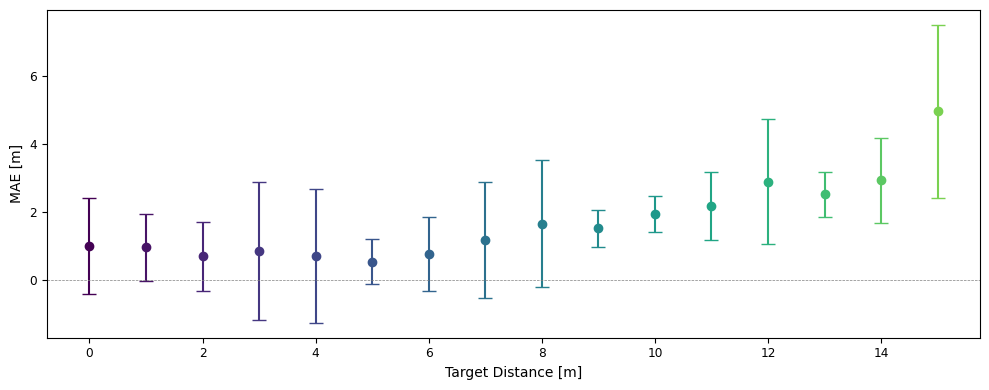

Min mean error: 0.5334013024819702
Max mean error: 4.96502847723236
Std error: 1.144687403496991
mean error: 1.6989075165439462
Min std error: 0.5288108911095432
Max std error: 2.5498766453306594
Std error: 0.5912216439789648


In [7]:
current_path = os.getcwd()
#figpath = os.path.join(current_path, '..', '..', 'Thesis', 'Thesis Github', 'thesis', 'figures')

errors = np.abs(y_test - y_pred)

# bin errors by distance, in binsize=1 m bins, but put everything from 7m on in one bin
bins = np.arange(0, 8, 0.5)
bins = np.append(bins, 20)
bin_indices = np.digitize(y_test, bins)

# calculate mean and standard deviation of errors per bin
mean_errors_per_bin = np.array([np.mean(errors[bin_indices == i]) for i in range(1, len(bins))])
std_errors_per_bin = np.array([np.std(errors[bin_indices == i]) for i in range(1, len(bins))])

# plot depending on distance
fig, ax = plt.subplots(figsize=(10, 4))

colors = plt.cm.viridis(np.linspace(0, 0.8, len(std_errors_per_bin)))  # You can choose any colormap

# Plot each data point with a different color
for i in range(len(std_errors_per_bin)):
    plt.errorbar(i, mean_errors_per_bin[i], yerr=std_errors_per_bin[i], fmt='o', color=colors[i], capsize=5)

#plt.show()
#plt.errorbar(np.unique(idx), mean_ang_diff_per_id, yerr=std_ang_diff_per_id, fmt='o', color=basecolor)
plt.xlabel('Target Distance [m]')
plt.ylabel('MAE [m]')
# add horizontal line at y=0
plt.axhline(0, color='grey', linewidth=0.5, linestyle='--')
plt.tight_layout()
#plt.savefig(os.path.join(figpath, 'svr_mse_error_over_distance.pdf'), format='pdf', dpi=1000)
plt.show()

print('Min mean error:', np.min(mean_errors_per_bin))
print('Max mean error:', np.max(mean_errors_per_bin))
print('Std error:', np.std(mean_errors_per_bin))
print('mean error:', np.mean(mean_errors_per_bin))
print('Min std error:', np.min(std_errors_per_bin))
print('Max std error:', np.max(std_errors_per_bin))
print('Std error:', np.std(std_errors_per_bin))

In [8]:
# fit linear regression on y_pred and y_test
slope, intercept = np.polyfit(y_test, y_pred, 1)
print('slope:', slope)
print('intercept:', intercept)

slope: 0.4550875957591229
intercept: 1.4033784022747842


In [9]:
# adjust figure settings for export

figwidth_fraction = 0.5
base_font_size_labels = 8
base_font_size_ticks = 7

label_font_size = base_font_size_labels / figwidth_fraction
tick_font_size = base_font_size_ticks / figwidth_fraction

params_plt = {'legend.fontsize': label_font_size,
         'axes.labelsize': label_font_size,
         'axes.titlesize': label_font_size,
         'xtick.labelsize': tick_font_size,
         'ytick.labelsize': tick_font_size}
pylab.rcParams.update(params_plt)

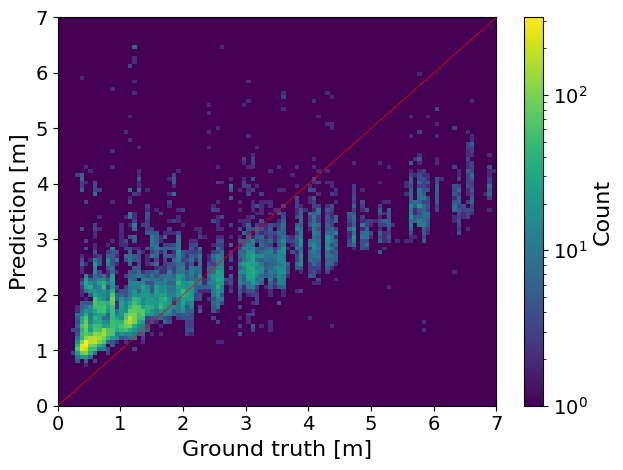

Metrics:
Mean squared error: 4.5325369350956715
RMSE: 2.1289755600043114
Mean absolute error: 1.220757349695328
Mean error: 0.11325226807773067
R^2: -0.16225583001560584
Median absolute error: 0.6869575778204942
In diopters:
Mean squared error 0.5327756227634131
RMSE:  0.7299148051405815
Mean absolute error 0.49026413785733597
Mean error -0.4310774974919357
R^2 -8.897246736945696
Median absolute error:  0.21987712783295588
Percent below 0.125 diopters: 36.708860759493675


In [10]:
evaluate(y_test, y_pred)

### (1.1) Is the bad performance coming from overfitting on the training data?

In [11]:
y_pred_train = model.predict(X_train)

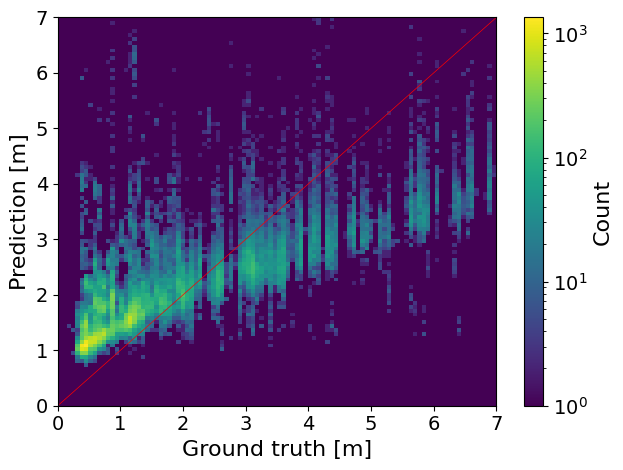

Metrics:
Mean squared error: 4.465992899255258
RMSE: 2.113289591905297
Mean absolute error: 1.2267819693593913
Mean error: 0.112081399417116
R^2: -0.15516475081475
Median absolute error: 0.6879971372495947
In diopters:
Mean squared error 0.5389228152537023
RMSE:  0.7341136255742038
Mean absolute error 0.4932567242242525
Mean error -0.4343203122925922
R^2 -8.95554941510943
Median absolute error:  0.22138207821343114
Percent below 0.125 diopters: 36.7847288698688


In [12]:
evaluate(y_train, y_pred_train)

The performance on the training set shows similar performance -> does not seem to overfit

### (2) Force the model to use other hyperparameters

In [13]:
model_best_paramters = SVR(kernel='rbf', C=100, epsilon=0.1)
model_best_paramters.fit(X_train, y_train)

SVR(C=100)

In [14]:
y_pred_best_parameters = model_best_paramters.predict(X_test)

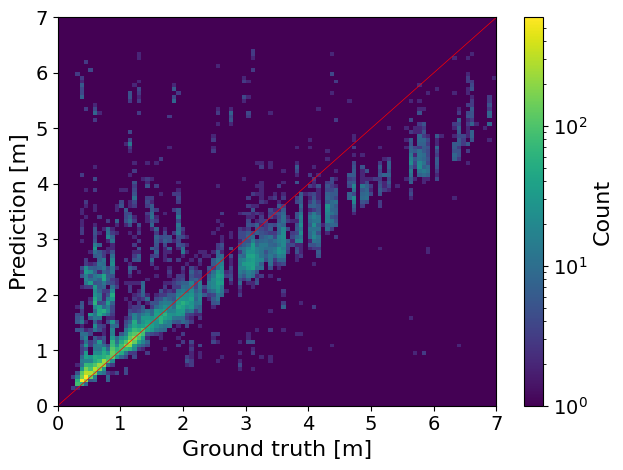

Metrics:
Mean squared error: 8.583781067571936
RMSE: 2.929809049677459
Mean absolute error: 1.0353641223643917
Mean error: 0.2547374121941268
R^2: 0.2584224931939971
Median absolute error: 0.24867459073593323
In diopters:
Mean squared error 0.22261127612637988
RMSE:  0.471816994317055
Mean absolute error 0.2571283528607925
Mean error -0.1883153576902596
R^2 0.3644115936762642
Median absolute error:  0.0802982821666034
Percent below 0.125 diopters: 59.80900040542366


In [15]:
evaluate(y_test, y_pred_best_parameters)

### (3) Try CV over ‘neg_mean_absolute_error’ to prevent from weird outlier effects

In [16]:
# take random 10% of the data to make training faster
data_reduced = data.sample(frac=0.1, random_state=42)

In [17]:
display(data_reduced)

,center,mean_distance,var_distance,mean_depth,var_depth,ray,wang,ecc,depth,distance,target_id,participant_id
32388,2.030945,1.947566,1.420685e-06,1.902466,0.000027,2.420710,2.421855,9.044204,2.031848,2.060257,262,15
101958,6.005859,25.430468,3.592695e-03,25.015259,0.002442,2.066093,-2.041730,8.142649,5.990398,6.042920,164,40
65507,1.258850,1.126081,8.624635e-06,1.115646,0.000012,1.594744,1.650604,7.166730,1.241079,1.254207,65,27
22019,5.502319,14.272304,6.802479e+01,13.567200,61.363923,52.250244,-240.023951,12.799807,5.496670,5.628475,32,11
66860,5.932617,50.674679,6.214371e-04,50.000000,0.000000,10.503112,15.469475,4.266060,5.913225,5.931737,119,27
...,...,...,...,...,...,...,...,...,...,...,...,...
32867,0.463486,3.306007,7.543860e-05,3.231812,0.000213,0.414152,0.443792,6.996956,0.461745,0.464564,135,15
74386,3.077698,3.419630,5.259022e-05,3.314209,0.000000,3.436510,3.935692,19.810242,3.024796,3.231054,179,30
21790,7.763672,19.485750,3.587324e+02,18.658142,327.437648,2.190865,2.230619,11.045897,1.267365,1.286013,62,11
83989,2.525330,0.358492,3.921433e-07,0.347805,0.000001,0.599659,0.693392,13.823890,0.566279,0.583869,249,34


In [18]:
# do train test split
df_X = data_reduced[['center', 'mean_distance', 'var_distance', 'ray', 'wang', 'ecc']]
df_distance_y = data_reduced['distance']

X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(df_X, df_distance_y, test_size=0.2, random_state=42)

print('X_train:', X_train_reduced.shape)
print('X_test:', X_test_reduced.shape)
print('y_train:', y_train_reduced.shape)
print('y_test:', y_test_reduced.shape)


X_train: (8879, 6)
X_test: (2220, 6)
y_train: (8879,)
y_test: (2220,)


In [19]:
# check weather the model already exists

model_reduced_mae = None
model_exists_mae = False
filename_mae_test = 'model_filtered_data_C_eps_mae_test.sav'


if os.path.exists(filename_mae_test):
    print('Model loaded')
    model_exists_mae = True
    model_reduced_mae = pickle.load(open(filename_mae_test, 'rb'))


if not model_exists_mae:
    # perform gridsearchcv with negative mean absolute error
    svr_rbf_mae = SVR(kernel='rbf')

    # define parameters for grid search
    parameters_mae = {'C': [0.1, 1, 10, 100, 1000, 10000],
                'epsilon': [0.001, 0.005, 0.01, 0.1, 0.5]}
    model_reduced_mae = GridSearchCV(svr_rbf_mae, parameters_mae, cv=5, scoring='neg_mean_absolute_error')

    # train model using cross validation
    model_reduced_mae.fit(X_train_reduced, y_train_reduced)
    
    # save model
    pickle.dump(model_reduced_mae, open(filename_mae_test, 'wb'))

# evaluate
print(model_reduced_mae.best_params_)
print(model_reduced_mae.best_score_)
print(model_reduced_mae.score(X_test_reduced, y_test_reduced))



Model loaded
{'C': 1000, 'epsilon': 0.001}
-0.6758977480233449
-0.6430511868572943


In [20]:
y_pred_reduced = model_reduced_mae.predict(X_test_reduced)

In [21]:
figwidth_fraction = 0.8
base_font_size_labels = 8
base_font_size_ticks = 7

label_font_size = base_font_size_labels / figwidth_fraction
tick_font_size = base_font_size_ticks / figwidth_fraction

params_plt = {'legend.fontsize': label_font_size,
         'axes.labelsize': label_font_size,
         'axes.titlesize': label_font_size,
         'xtick.labelsize': tick_font_size,
         'ytick.labelsize': tick_font_size}
pylab.rcParams.update(params_plt)

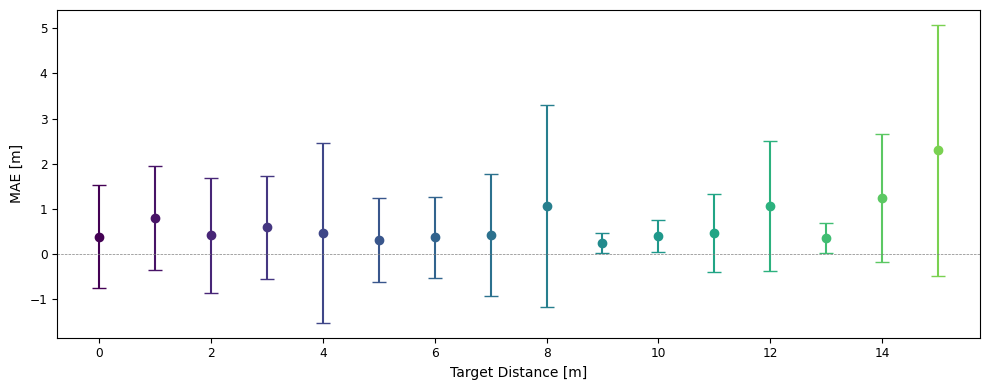

Min mean error: 0.23500147362800128
Max mean error: 2.291479968163885
Std error: 0.5109068860361068
mean error: 0.67463960883915
Min std error: 0.22089426325289885
Max std error: 2.7858621531420162


In [22]:
errors = np.abs(y_test_reduced - y_pred_reduced)

# bin errors by distance, in binsize=1 m bins, but put everything from 7m on in one bin
bins = np.arange(0, 8, 0.5)
bins = np.append(bins, 20)
bin_indices = np.digitize(y_test_reduced, bins)

# calculate mean and standard deviation of errors per bin
mean_errors_per_bin = np.array([np.mean(errors[bin_indices == i]) for i in range(1, len(bins))])
std_errors_per_bin = np.array([np.std(errors[bin_indices == i]) for i in range(1, len(bins))])

# plot depending on distance
fig, ax = plt.subplots(figsize=(10, 4))

colors = plt.cm.viridis(np.linspace(0, 0.8, len(std_errors_per_bin)))  # You can choose any colormap

# Plot each data point with a different color
for i in range(len(std_errors_per_bin)):
    plt.errorbar(i, mean_errors_per_bin[i], yerr=std_errors_per_bin[i], fmt='o', color=colors[i], capsize=5)

plt.xlabel('Target Distance [m]')
plt.ylabel('MAE [m]')

# add horizontal line at y=0
plt.axhline(0, color='grey', linewidth=0.5, linestyle='--')
plt.tight_layout()
#plt.savefig(os.path.join(figpath, 'svr_mae_reduced_error_over_distance.pdf'), format='pdf', dpi=1000)
plt.show()

print('Min mean error:', np.min(mean_errors_per_bin))
print('Max mean error:', np.max(mean_errors_per_bin))
print('Std error:', np.std(mean_errors_per_bin))
print('mean error:', np.mean(mean_errors_per_bin))
print('Min std error:', np.min(std_errors_per_bin))
print('Max std error:', np.max(std_errors_per_bin))



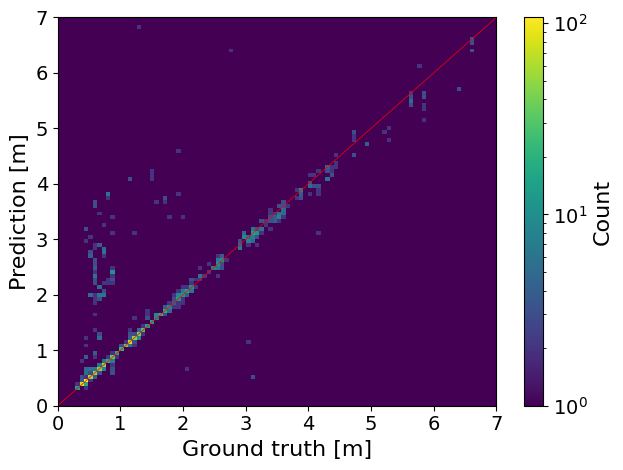

Metrics:
Mean squared error: 2.5249910033029246
RMSE: 1.5890220273183517
Mean absolute error: 0.6430511868572943
Mean error: 0.27776003912542824
R^2: 0.5936419549245509
Median absolute error: 0.04654470446444492
In diopters:
Mean squared error 0.37564467559769504
RMSE:  0.6128985850837764
Mean absolute error 0.2191448772778273
Mean error -0.13518009348719853
R^2 0.4793824029221033
Median absolute error:  0.012553366851318137
Percent below 0.125 diopters: 76.44144144144144


In [23]:
# plot a 2d histogram of the vergence estimation vs target distance
figwidth_fraction = 0.5
base_font_size_labels = 8
base_font_size_ticks = 7

label_font_size = base_font_size_labels / figwidth_fraction
tick_font_size = base_font_size_ticks / figwidth_fraction

params_plt = {'legend.fontsize': label_font_size,
         'axes.labelsize': label_font_size,
         'axes.titlesize': label_font_size,
         'xtick.labelsize': tick_font_size,
         'ytick.labelsize': tick_font_size}
pylab.rcParams.update(params_plt)

evaluate(y_test_reduced, y_pred_reduced)

# Leave one subject out CV with MAE as error function: FINAL MODEL, comparable to the others regarding the approach

In [24]:
# auf 30 subjects ods cross validation -> test auf den 11 mit den parametern
train_percentage = 0.75
test_percentage = 0.25

subjs = range(3, 44)

# take train_percentage of the subjects
np.random.seed(42)
train_subjs = np.random.choice(subjs, int(train_percentage * len(subjs)), replace=False)
test_subjs = np.setdiff1d(subjs, train_subjs)

print('Train subjects:', train_subjs)
print('Test subjects:', test_subjs)

Train subjects: [27 16 11 28  7 43 22 42 32  9 29 15 20 12 18 35 19 38 37  3 30  8 14  4
 33 24  5 34 40  6]
Test subjects: [10 13 17 21 23 25 26 31 36 39 41]


In [25]:
train_set = data[data['participant_id'].isin(train_subjs)]
test_set = data[data['participant_id'].isin(test_subjs)]

# shuffle data
train_set = train_set.sample(frac=1)
test_set = test_set.sample(frac=1)

display(train_set)
display(test_set)

,center,mean_distance,var_distance,mean_depth,var_depth,ray,wang,ecc,depth,distance,target_id,participant_id
30253,2.993774,11.457928,0.003576,11.311951,0.004985,1.535417,1.621052,10.786930,7.491652,7.615511,70,14
7281,0.550842,1.567939,0.311207,1.504860,0.284782,0.453596,0.482519,15.162414,0.537644,0.556487,232,6
36381,0.422668,3.071736,0.000555,2.909470,0.000923,0.444192,0.445193,20.675661,0.427884,0.457226,144,16
42789,1.020050,41.107908,50.939492,40.960693,50.751381,0.839258,1.046144,1.549898,1.019183,1.019687,130,18
32595,0.354004,1.926741,0.988960,1.907501,0.967671,0.304948,0.337536,2.078301,0.353860,0.354024,255,15
...,...,...,...,...,...,...,...,...,...,...,...,...
56899,0.347900,2.277042,1.225692,2.228203,1.176222,0.419777,0.435523,14.773350,0.344706,0.359118,256,24
101580,0.406647,6.788107,0.000037,6.701050,0.000022,0.311030,0.334073,4.808042,0.403596,0.405606,87,40
8792,3.016663,1.782341,0.000071,1.750183,0.000082,0.655824,2.417339,6.092946,1.172436,1.176769,159,6
10627,1.252747,4.114526,10.556613,4.109230,10.524998,0.929514,1.216529,6.841340,1.279742,1.290989,63,7


,center,mean_distance,var_distance,mean_depth,var_depth,ray,wang,ecc,depth,distance,target_id,participant_id
77125,0.465393,0.691147,3.808455e-03,0.663052,3.443526e-03,0.427765,0.437143,18.298992,0.464990,0.492143,161,31
89097,0.511932,2.299448,6.679194e-02,2.256317,6.570925e-02,0.447239,0.475640,11.791752,0.512486,0.522067,12,36
62057,2.619934,4.176178,1.436872e-04,4.166565,1.099892e-04,2.016770,3.569228,2.614536,2.624374,2.627420,141,26
20469,3.085327,3.758599,6.537146e-02,3.651123,6.275754e-02,3.108064,3.103642,11.507391,3.073781,3.139828,186,10
55567,25.268555,2.105558,4.091834e-06,2.100449,8.090865e-07,5.492766,22.301559,7.539385,7.155825,7.218178,185,23
...,...,...,...,...,...,...,...,...,...,...,...,...
61220,4.821777,3.045474,6.021884e-05,3.038940,4.642643e-05,1.348760,1.393391,2.833161,4.828186,4.831575,126,25
51145,7.952881,9.585643,3.491892e-02,9.570923,3.633238e-02,3.104431,-4.036104,3.306755,7.863626,7.876177,22,21
54157,3.106689,1.512989,1.600487e-07,1.486511,4.307367e-07,1.834808,2.708802,6.500802,3.107348,3.127793,175,23
62140,0.486374,6.312178,5.090712e-06,6.284180,2.011657e-05,0.416339,0.471154,1.473644,0.486321,0.486818,52,26


In [26]:
X_train_subj = train_set[['center', 'mean_distance', 'var_distance', 'ray', 'wang', 'ecc']].to_numpy()
y_train_subj = train_set['distance'].to_numpy()
train_ids = train_set['participant_id'].to_numpy()

X_test_subj = test_set[['center', 'mean_distance', 'var_distance', 'ray', 'wang', 'ecc']].to_numpy()
y_test_subj = test_set['distance'].to_numpy()
test_ids = test_set['participant_id'].to_numpy()

In [27]:
# check weather the model already exists
model_mae = None
model_exists_mae = False
filename_mae = 'final_model.sav'


if os.path.exists(filename_mae):
    print('Model loaded')
    model_exists_mae = True
    model_mae = pickle.load(open(filename_mae, 'rb'))


if not model_exists_mae:
    # perform gridsearchcv with negative mean absolute error
    svr_rbf_mae = SVR(kernel='rbf')

    # define parameters for grid search
    parameters_mae = {'C': [0.1, 1, 10, 100, 1000, 10000],
                'epsilon': [0.001, 0.005, 0.01, 0.1, 0.5]}
    model_mae = GridSearchCV(svr_rbf_mae, parameters_mae, cv=5, scoring='neg_mean_absolute_error')

    # train model using cross validation
    model_mae.fit(X_train_subj, y_train_subj)
    
    # save model
    pickle.dump(model_mae, open(filename_mae, 'wb'))

# evaluate
print(model_mae.best_params_)
print(model_mae.best_score_)
print(model_mae.score(X_test_subj, y_test_subj))

Model loaded
{'C': 10000, 'epsilon': 0.001}
-0.7088634717655948
-0.7231856339324871


In [28]:
y_pred_subj = model_mae.predict(X_test_subj)

In [29]:
figwidth_fraction = 0.8
base_font_size_labels = 8
base_font_size_ticks = 7

label_font_size = base_font_size_labels / figwidth_fraction
tick_font_size = base_font_size_ticks / figwidth_fraction

params_plt = {'legend.fontsize': label_font_size,
         'axes.labelsize': label_font_size,
         'axes.titlesize': label_font_size,
         'xtick.labelsize': tick_font_size,
         'ytick.labelsize': tick_font_size}
pylab.rcParams.update(params_plt)

30378
[10 13 17 21 23 25 26 31 36 39 41]


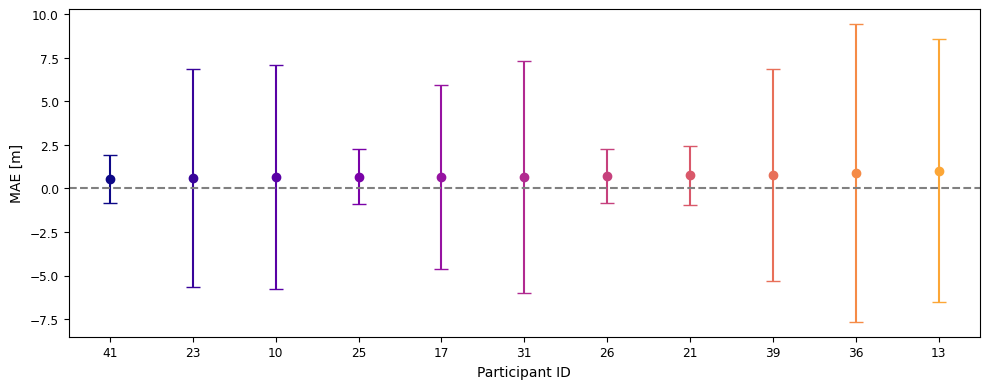

Min error per subject: 0.5445686588619645
Max error per subject: 1.0243769488811154
Mean error per subject: 0.7241083900053543
Std error per subject: 0.12919961078333841
Median error per subject: 0.6771502341842874
Min std per subject: 1.3527139962830443
Max std per subject: 8.540642821313584
Mean std per subject: 4.823846043100191
Min mse per subject: 2.126390179954763
Max mse per subject: 73.72113138502951
Mean mse per subject: 30.55465513901332
Std mse per subject: 23.69004538127843
Median mse per subject: 37.905240409671904


In [30]:
# compute mse per subject
mse_per_subject = []

for subj in test_subjs:
    idx = test_ids == subj
    mse_per_subject.append(np.mean((y_test_subj[idx] - y_pred_subj[idx]) ** 2))

# compute mean error and std error per subject
mean_error_per_subject = []
std_error_per_subject = []

print(len(test_ids))
print(test_subjs)

for subj in test_subjs:
    idx = test_ids == subj
    mean_error_per_subject.append(np.mean(np.abs(y_pred_subj[idx] - y_test_subj[idx])))
    std_error_per_subject.append(np.std(np.abs(y_pred_subj[idx] - y_test_subj[idx])))

# sort by mean error, save participant ids
sorted_idx = np.argsort(mean_error_per_subject)
sorted_subjs = test_subjs[sorted_idx]
mean_error_per_subject = np.array(mean_error_per_subject)[sorted_idx]
std_error_per_subject = np.array(std_error_per_subject)[sorted_idx]

# plot depending on distance
fig, ax = plt.subplots(figsize=(10, 4))

colors = plt.cm.plasma(np.linspace(0, 0.8, len(mean_error_per_subject)))  # You can choose any colormap

# Plot each data point with a different color
for i in range(len(std_error_per_subject)):
    plt.errorbar(i, mean_error_per_subject[i], yerr=std_error_per_subject[i], fmt='o', color=colors[i], capsize=5)

# add ticks for each subject
plt.xticks(range(len(mean_error_per_subject)), sorted_subjs)

# add dashed line at 0
plt.axhline(0, color='grey', linestyle='--')

plt.xlabel('Participant ID')
plt.ylabel('MAE [m]')
plt.tight_layout()
#plt.savefig('svr_mae_error_per_subj.pdf', format='pdf', dpi=1000)
#plt.savefig(os.path.join(figpath, 'svr_mae_error_per_subj.pdf'), format='pdf', dpi=1000)
plt.show()

# print min and max error per subject
print('Min error per subject:', np.min(mean_error_per_subject))
print('Max error per subject:', np.max(mean_error_per_subject))
print('Mean error per subject:', np.mean(mean_error_per_subject))
print('Std error per subject:', np.std(mean_error_per_subject))
print('Median error per subject:', np.median(mean_error_per_subject))

print('Min std per subject:', np.min(std_error_per_subject))
print('Max std per subject:', np.max(std_error_per_subject))
print('Mean std per subject:', np.mean(std_error_per_subject))
# print min and max mse per subject
print('Min mse per subject:', np.min(mse_per_subject))
print('Max mse per subject:', np.max(mse_per_subject))
print('Mean mse per subject:', np.mean(mse_per_subject))
print('Std mse per subject:', np.std(mse_per_subject))
print('Median mse per subject:', np.median(mse_per_subject))


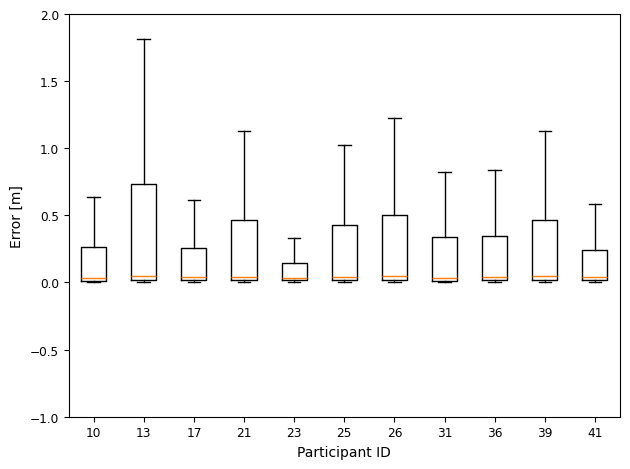

In [31]:
# get the error values per subject
error_values = []

for subj in test_subjs:
    idx = test_ids == subj
    error_values.append(np.abs(y_pred_subj[idx] - y_test_subj[idx]))

#print(error_values)

# plot boxplot of errors per subject
plt.boxplot(error_values, showfliers=False)
plt.xticks(range(1, len(test_subjs) + 1), test_subjs)
plt.xlabel('Participant ID')
plt.ylabel('Error [m]')
plt.ylim(-1,2)
plt.tight_layout()
#plt.savefig(os.path.join(figpath, 'svr_mae_error_per_subj_boxplot.pdf'), format='pdf', dpi=1000)
plt.show()

30378
[10 13 17 21 23 25 26 31 36 39 41]


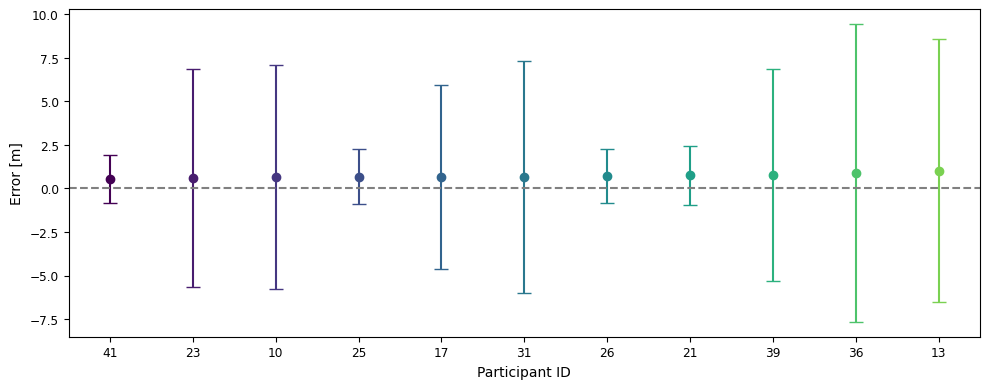

Min error per subject: 0.5445686588619645
Max error per subject: 1.0243769488811154
Mean error per subject: 0.7241083900053543
Std error per subject: 0.12919961078333841
Median error per subject: 0.6771502341842874
Min std per subject: 1.3527139962830443
Max std per subject: 8.540642821313584
Mean std per subject: 4.823846043100191
Min mse per subject: 2.126390179954763
Max mse per subject: 73.72113138502951
Mean mse per subject: 30.55465513901332
Std mse per subject: 23.69004538127843
Median mse per subject: 37.905240409671904


In [32]:
# compute mse per subject
mse_per_subject = []

for subj in test_subjs:
    idx = test_ids == subj
    mse_per_subject.append(np.mean((y_test_subj[idx] - y_pred_subj[idx]) ** 2))

# compute mean error and std error per subject
mean_error_per_subject = []
std_error_per_subject = []

print(len(test_ids))
print(test_subjs)

for subj in test_subjs:
    idx = test_ids == subj
    mean_error_per_subject.append(np.mean(np.abs(y_pred_subj[idx] - y_test_subj[idx])))
    std_error_per_subject.append(np.std(np.abs(y_pred_subj[idx] - y_test_subj[idx])))

# sort by mean error, save participant ids
sorted_idx = np.argsort(mean_error_per_subject)
sorted_subjs = test_subjs[sorted_idx]
mean_error_per_subject = np.array(mean_error_per_subject)[sorted_idx]
std_error_per_subject = np.array(std_error_per_subject)[sorted_idx]

# plot depending on distance
fig, ax = plt.subplots(figsize=(10, 4))

colors = plt.cm.viridis(np.linspace(0, 0.8, len(mean_error_per_subject)))  # You can choose any colormap

# Plot each data point with a different color
for i in range(len(std_error_per_subject)):
    plt.errorbar(i, mean_error_per_subject[i], yerr=std_error_per_subject[i], fmt='o', color=colors[i], capsize=5)

# add ticks for each subject
plt.xticks(range(len(mean_error_per_subject)), sorted_subjs)

# add dashed line at 0
plt.axhline(0, color='grey', linestyle='--')

plt.xlabel('Participant ID')
plt.ylabel('Error [m]')
plt.tight_layout()
#plt.savefig(os.path.join(figpath, 'svr_mae_error_per_subj.pdf'), format='pdf', dpi=1000)
plt.show()

# print min and max error per subject
print('Min error per subject:', np.min(mean_error_per_subject))
print('Max error per subject:', np.max(mean_error_per_subject))
print('Mean error per subject:', np.mean(mean_error_per_subject))
print('Std error per subject:', np.std(mean_error_per_subject))
print('Median error per subject:', np.median(mean_error_per_subject))

print('Min std per subject:', np.min(std_error_per_subject))
print('Max std per subject:', np.max(std_error_per_subject))
print('Mean std per subject:', np.mean(std_error_per_subject))
# print min and max mse per subject
print('Min mse per subject:', np.min(mse_per_subject))
print('Max mse per subject:', np.max(mse_per_subject))
print('Mean mse per subject:', np.mean(mse_per_subject))
print('Std mse per subject:', np.std(mse_per_subject))
print('Median mse per subject:', np.median(mse_per_subject))


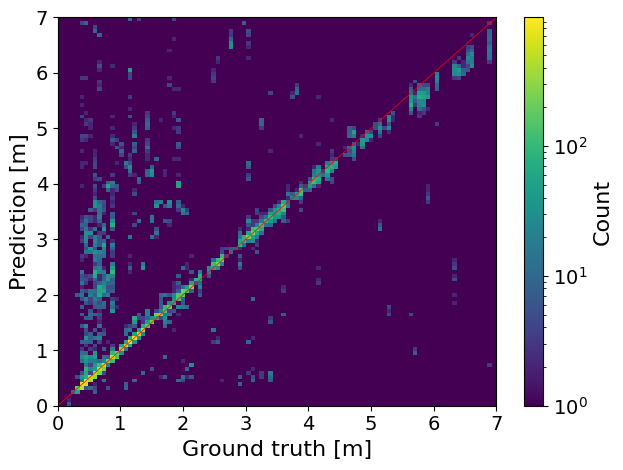

Metrics:
Mean squared error: 30.295394116840388
RMSE: 5.50412519087642
Mean absolute error: 0.7231856339324871
Mean error: 0.21427810098287867
R^2: 0.09745011630797262
Median absolute error: 0.03943639134591803
In diopters:
Mean squared error 0.26305708817287843
RMSE:  0.5128909125465945
Mean absolute error 0.2128043731751868
Mean error -0.10613273144991715
R^2 0.6293215017554481
Median absolute error:  0.015004781585525068
Percent below 0.125 diopters: 70.80452959378498


In [33]:
figwidth_fraction = 0.5
base_font_size_labels = 8
base_font_size_ticks = 7

label_font_size = base_font_size_labels / figwidth_fraction
tick_font_size = base_font_size_ticks / figwidth_fraction

params_plt = {'legend.fontsize': label_font_size,
         'axes.labelsize': label_font_size,
         'axes.titlesize': label_font_size,
         'xtick.labelsize': tick_font_size,
         'ytick.labelsize': tick_font_size}
pylab.rcParams.update(params_plt)

evaluate(y_test_subj, y_pred_subj)

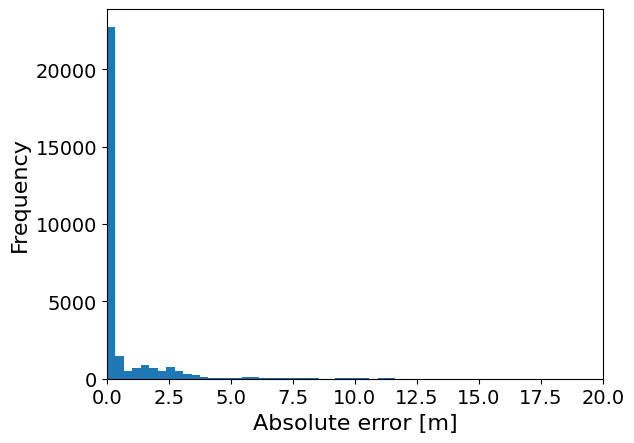

In [34]:
error = np.abs(y_test_subj - y_pred_subj)
# print histogram
plt.hist(error, bins=1000)
plt.xlabel('Absolute error [m]')
plt.ylabel('Frequency')

# set max value for x axis
plt.xlim(0, 20)
plt.show()

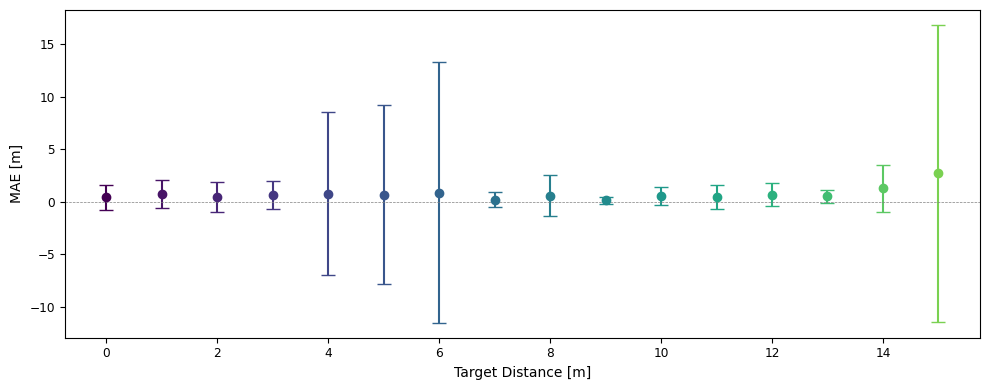

Min mean error: 0.15550197903449087
Max mean error: 2.720674781216294
Std error: 0.5745826027086733
mean error: 0.7302269265697312
Min std error: 0.3186965107833284
Max std error: 14.142591690652068


In [35]:
figwidth_fraction = 0.8
base_font_size_labels = 8
base_font_size_ticks = 7

label_font_size = base_font_size_labels / figwidth_fraction
tick_font_size = base_font_size_ticks / figwidth_fraction

params_plt = {'legend.fontsize': label_font_size,
         'axes.labelsize': label_font_size,
         'axes.titlesize': label_font_size,
         'xtick.labelsize': tick_font_size,
         'ytick.labelsize': tick_font_size}
pylab.rcParams.update(params_plt)

errors = np.abs(y_test_subj - y_pred_subj)

# bin errors by distance, in binsize=1 m bins, but put everything from 7m on in one bin
bins = np.arange(0, 8, 0.5)
bins = np.append(bins, 20)
bin_indices = np.digitize(y_test_subj, bins)

# calculate mean and standard deviation of errors per bin
mean_errors_per_bin = np.array([np.mean(errors[bin_indices == i]) for i in range(1, len(bins))])
std_errors_per_bin = np.array([np.std(errors[bin_indices == i]) for i in range(1, len(bins))])

# plot depending on distance
fig, ax = plt.subplots(figsize=(10, 4))

colors = plt.cm.viridis(np.linspace(0, 0.8, len(std_errors_per_bin)))  # You can choose any colormap

# Plot each data point with a different color
for i in range(len(std_errors_per_bin)):
    plt.errorbar(i, mean_errors_per_bin[i], yerr=std_errors_per_bin[i], fmt='o', color=colors[i], capsize=5)

#plt.show()
#plt.errorbar(np.unique(idx), mean_ang_diff_per_id, yerr=std_ang_diff_per_id, fmt='o', color=basecolor)
plt.xlabel('Target Distance [m]')
plt.ylabel('MAE [m]')
# add horizontal line at y=0
plt.axhline(0, color='grey', linewidth=0.5, linestyle='--')
plt.tight_layout()
#plt.savefig(os.path.join(figpath, 'svr_mae_subj_error_over_distance.pdf'), format='pdf', dpi=1000)
plt.show()

print('Min mean error:', np.min(mean_errors_per_bin))
print('Max mean error:', np.max(mean_errors_per_bin))
print('Std error:', np.std(mean_errors_per_bin))
print('mean error:', np.mean(mean_errors_per_bin))
print('Min std error:', np.min(std_errors_per_bin))
print('Max std error:', np.max(std_errors_per_bin))

